<a href="https://colab.research.google.com/github/rameyer/CALF/blob/master/ProgressiveGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q pyyaml h5py
!pip install --upgrade -q gspread
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
import os

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


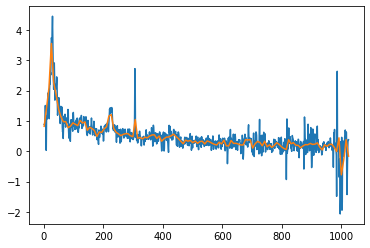

In [0]:
from google.colab import files
import numpy as np
from scipy.optimize import curve_fit, minimize
import time
from matplotlib import pyplot as plt

############## LOAD AND REBIN THE ORIGINAL N=1024 TRAINING SPECTRA #############

def rebin_array(data_array, binning):
  return np.transpose(np.array([np.mean(data_array[:,i:i+binning],axis=-1) for i in range(0,len(data_array[0]),binning)]))

training_set_1024 = np.load('/gdrive/My Drive/training_set_BOSS_p1.npy')

training_set_512 = rebin_array(training_set_1024,2)

training_set_256 = rebin_array(training_set_1024,4)

training_set_128 = rebin_array(training_set_1024,8)

training_set_64 = rebin_array(training_set_1024,16)

training_set_32 = rebin_array(training_set_1024,32)

#### For testing/checking purposes only ######
if True:
  plt.plot(np.linspace(1,1024,1024), training_set_1024[0])
  plt.plot(np.linspace(1,1024,128),training_set_128[0])
  plt.show()


In [0]:
################## CREATING GAN ##################

from keras import layers
from keras import Model
from keras.layers import Layer, Input, Dense
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.optimizers import Adam
import keras
class WeightedSum(Layer):
    def __init__(self, alpha=0.0,name_number=0, **kwargs):
        super(WeightedSum, self).__init__(**kwargs)
        self.alpha = keras.backend.variable(alpha, name='discrim'+str(name_number)+'_ws_alpha')
    def call(self, inputs):
        assert(len(inputs)==2)
        return self.alpha * inputs[0] + (1 - self.alpha) * inputs[1]

class GAN:
    def __init__(self,n_blocks,input_length_min):
        self.D_list = self.discriminators(n_blocks,input_length_min)
      
        #self.G = self.generator()

        #latent = Input(shape=(self.LATENT_DIM, ))

        #gen_spec = self.G(latent)

        #self.D.trainable = False

        #p_true =self.D(gen_spec)

        #self.GAN_model = Model(inputs=latent,
        #                       outputs=p_true)

        #self.GAN_model.summary()

        #self.GAN_model.compile(optimizer='adam',loss=['binary_crossentropy'])

    def update_fadein(self, step_n,alpha):
        for layer in self.D_list[step_n].layers:
			      if isinstance(layer, WeightedSum):
				        backend.set_value(layer.alpha, alpha)
            
    def discriminator_block(self,input):
        N_filters = int(input.shape[-1])
        
        mid = layers.Conv1D(filters=N_filters, kernel_size=3, strides=1, 
                            padding='same',activation = LeakyReLU(alpha=0.1),name='discrim'+str(self.counter)+'_conv1')(input)
        mid = layers.Conv1D(filters=int(N_filters*2), kernel_size=3, strides=1, 
                            padding='same',activation = LeakyReLU(alpha=0.1),name='discrim'+str(self.counter)+'_conv2')(mid)
        mid = layers.AveragePooling1D(pool_size=2,name='discrim'+str(self.counter)+'_pool_B')(mid)            

        return mid

    def discriminators(self,n_blocks,input_length_min):
        model_list = [] 
        self.counter = 0
        input = Input(shape=(int(input_length_min/(2**n_blocks)),),name='input'+str(self.counter)+'' )

        reshaped_input = layers.Reshape((int(input_length_min/2**n_blocks),1),name='input'+str(self.counter)+'_reshape' )(input)
        mid = layers.Conv1D(filters=2**n_blocks, kernel_size=3, strides=1, 
                            padding='same',activation = LeakyReLU(alpha=0.1),name='input'+str(self.counter)+'_conv')(reshaped_input)
        mid = self.discriminator_block(mid)
        mid = layers.Flatten(name='discrim'+str(self.counter)+'_Flatten')(mid)
        p_true = layers.Dense(1,activation='sigmoid',name='discrim'+str(self.counter)+'_FinalDense')(mid)

        old_model = Model(input,p_true)
        old_model.compile(loss='binary_crossentropy', 
                       optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))
        old_model.summary()
        self.counter+=1

        for i in range(1,n_blocks+1):

            input_new = Input(shape=(int(input_length_min/2**(n_blocks-i)),),name='input'+str(self.counter)+'')
            reshaped_input_new = layers.Reshape((int(input_length_min/2**(n_blocks-i)),1),name='input'+str(self.counter)+'_reshape')(input_new)
            conv = layers.Conv1D(filters=int(2**(n_blocks-i)), kernel_size=3, strides=1, 
                                padding='same',activation = LeakyReLU(alpha=0.1),name='input'+str(self.counter)+'_conv')(reshaped_input_new)
            downsampled = layers.AveragePooling1D(pool_size=2,name='input'+str(self.counter)+'_convdownsampled')(reshaped_input_new)
            conv_downsampled = old_model.layers[2](downsampled)            
            
            mid = WeightedSum(name_number=str(self.counter))([conv_downsampled,self.discriminator_block(conv)])
            print(len(old_model.layers))
            for j in range(3,len(old_model.layers)):
                if old_model.layers[j].name[0:7] == 'discrim' and int(old_model.layers[j].name[7]) < self.counter:
                    print(old_model.layers[j].input_shape,old_model.layers[j].output_shape)
                    mid = old_model.layers[j](mid)
            #print(mid.shape)
            #mid = layers.Flatten()(mid)
            #p_true_new = layers.Dense(1,activation='sigmoid')(mid)

            new_model =  Model(input_new,mid)
            new_model.compile(loss='binary_crossentropy', 
                       optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))
            
            model_list.append(new_model)
            new_model.summary()
            old_model = new_model
            self.counter+=1
        #for model in model_list:
        #    model.summary()
        return model_list




In [29]:
gan = GAN(4,1024)

/usr/local/lib/python3.6/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input0 (InputLayer)          (None, 64)                0         
_________________________________________________________________
input0_reshape (Reshape)     (None, 64, 1)             0         
_________________________________________________________________
input0_conv (Conv1D)         (None, 64, 16)            64        
_________________________________________________________________
discrim0_conv1 (Conv1D)      (None, 64, 16)            784       
_________________________________________________________________
discrim0_conv2 (Conv1D)      (None, 64, 32)            1568      
_________________________________________________________________
discrim0_pool_B (AveragePool (None, 32, 32)            0         
_________________________________________________________________
discrim0_Flatten (Flatten)   (None, 1024)              0  